In [1]:
import numpy as np
import pickle
import lzma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray
from experiment import AgentStats, Results
from typing import List, Dict


/home/alessior/anaconda3/envs/exploration-maze/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TITLE_SIZE = 22
LEGEND_SIZE = 14
TICK_SIZE = 14
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 16
FONT_SIZE = TITLE_SIZE-4

rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        r'\usepackage{amsmath}',
    ]
}
plt.rcParams.update(rc_parameters)


In [14]:
T = 200
agents = ['explorative','boot_dqn_torch','boot_dqn_torch_modified', 'ids']
sizes = [1,3,5,10]
data = {}
for agent in agents:
    data[agent] = {}
    for size in sizes:
        with lzma.open(f'data/data500/data_{size}_{agent}.pkl', 'rb') as f:
            data[agent][size] = pickle.load(f)

In [15]:


LABELS = {
    'boot_dqn_torch': 'BSP',
    'boot_dqn_torch_modified': 'BSP2',
    'explorative': 'DBMF-BPI',
    'ids': 'IDS',

}

def get_cumulative_upright(results: List[Results], T: int) -> NDArray[np.float64]:
    df = pd.DataFrame({'Episode': [], 'Value': []})
    ret = []
    for i in range(len(results)):
        ret.append(np.cumsum([np.sum(results[i].agent_stats.episodes_rewards[x] > 0) for x in range(T)]))
        for j, val in enumerate(ret[-1]):
            df.loc[len(df)] = [j, val]
    return np.vstack(ret), df


def get_cumulative_upright_full(results: Dict[str, Dict[int, List[Results]]], agents: List[str], sizes: List[int], T: int) -> NDArray[np.float64]:
    df = pd.DataFrame({'n': [], 'Value': [], 'Agent': []})
    for agent in agents:
        for size in sizes:
            for i in range(len(results[agent][size])):
                ret = np.cumsum([np.sum(results[agent][size][i].agent_stats.episodes_rewards[x] > 0) for x in range(T)])
                df.loc[len(df)] = [size, ret[-1], LABELS[agent]]
    return df

def get_greedy_eval(results: Dict[str, Dict[int, List[Results]]], agent: str, size: int) -> NDArray[np.float64]:
    greedy_data = np.array([list(zip(*results[agent][size][x].greedy_rewards))[1] for x in range(len(results[agent][size]))])
    return greedy_data

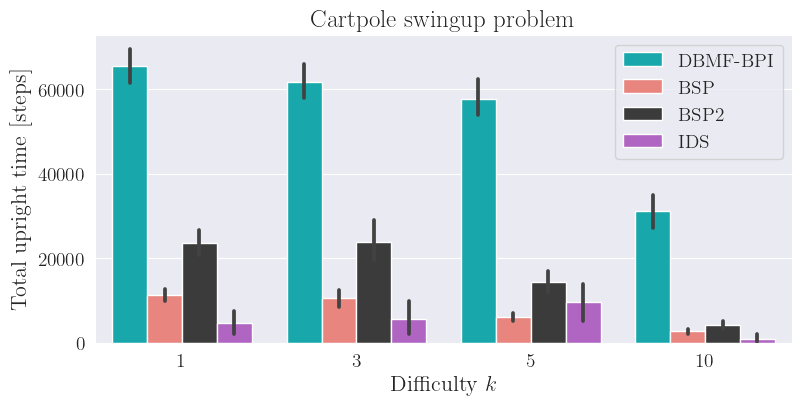

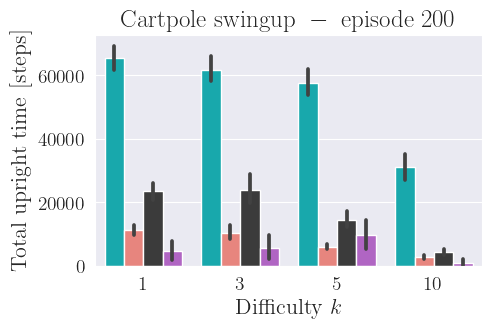

In [17]:
df = get_cumulative_upright_full(data, agents, sizes, T)
sns.set_style("darkgrid", rc=rc_parameters)
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']
color_dict = {agent: color for agent, color in zip(['BSP', 'DBMF-BPI', 'IDS', 'BSP2'], colors)}

fig, ax = plt.subplots(1,1, figsize=(9,4))
sns.barplot(x="n", y="Value", hue="Agent", data=df, palette=color_dict)
plt.xlabel(r'$\mathrm{Difficulty}$ $k$')
plt.ylabel(r'$\mathrm{Total \ upright \ time \ [steps]}$')
plt.title(r'$\mathrm{Cartpole \ swingup \ problem}$')
plt.legend()
plt.savefig('figures/total_upright_time_barplot.pdf', bbox_inches='tight')



colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']
color_dict = {agent: color for agent, color in zip(['BSP', 'DBMF-BPI', 'IDS', 'BSP2'], colors)}

fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.barplot(x="n", y="Value", hue="Agent", data=df, palette=color_dict)
plt.xlabel(r'$\mathrm{Difficulty}$ $k$')
plt.ylabel(r'$\mathrm{Total \ upright \ time \ [steps]}$')
plt.title(r'$\mathrm{Cartpole \ swingup \ - \ episode \ 200}$')
ax.get_legend().remove() 
# plt.legend()
plt.savefig('figures/total_upright_time_barplot_small.pdf', bbox_inches='tight')

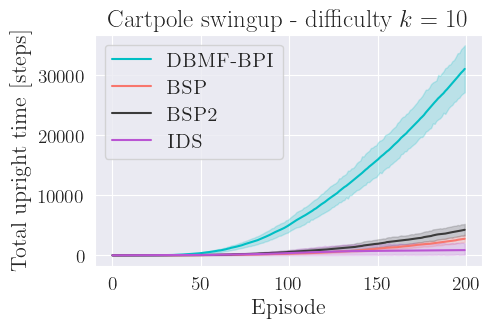

In [18]:
sns.set_style("darkgrid",rc=rc_parameters)

fig, ax = plt.subplots(1,1, figsize=(5,3))
labels = {
    'boot_dqn_torch': r'\textsc{BSP}',
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative': r'\textsc{DBMF-BPI}',
    'ids': r'\textsc{IDS}',

}
colors = {
    'boot_dqn_torch':'#f8766d',
    'boot_dqn_torch_modified':'#3B3B3B',
    'explorative': '#00bfc4',
    'ids':'mediumorchid',
}

for size in [10]:
    for agent_id, agent in enumerate(['explorative','boot_dqn_torch','boot_dqn_torch_modified', 'ids']):
        ret1,df1 = get_cumulative_upright(data[agent][size], T)
        sns.lineplot(x='Episode', y='Value', data=df1, label=labels[agent], color=colors[agent])

plt.xlabel(r'$\mathrm{Episode}$')
plt.ylabel(r'$\mathrm{Total \ upright \ time \ [steps]}$')
plt.title(r'$\mathrm{Cartpole \ swingup}$ - difficulty $k=10$')
# Get the current handles and labels of the plot
handles, labels = plt.gca().get_legend_handles_labels()

# Manually reorder the handles and labels
ordered_handles = handles# [handles[1], handles[0], handles[3], handles[2]]  # Change the order as desired
ordered_labels =labels# [labels[1], labels[0], labels[3], labels[2]]  # Change the order as desired

# Create the legend with the ordered handles and labels
plt.legend(ordered_handles, ordered_labels)
plt.savefig('figures/total_upright_time_10.pdf', bbox_inches='tight')

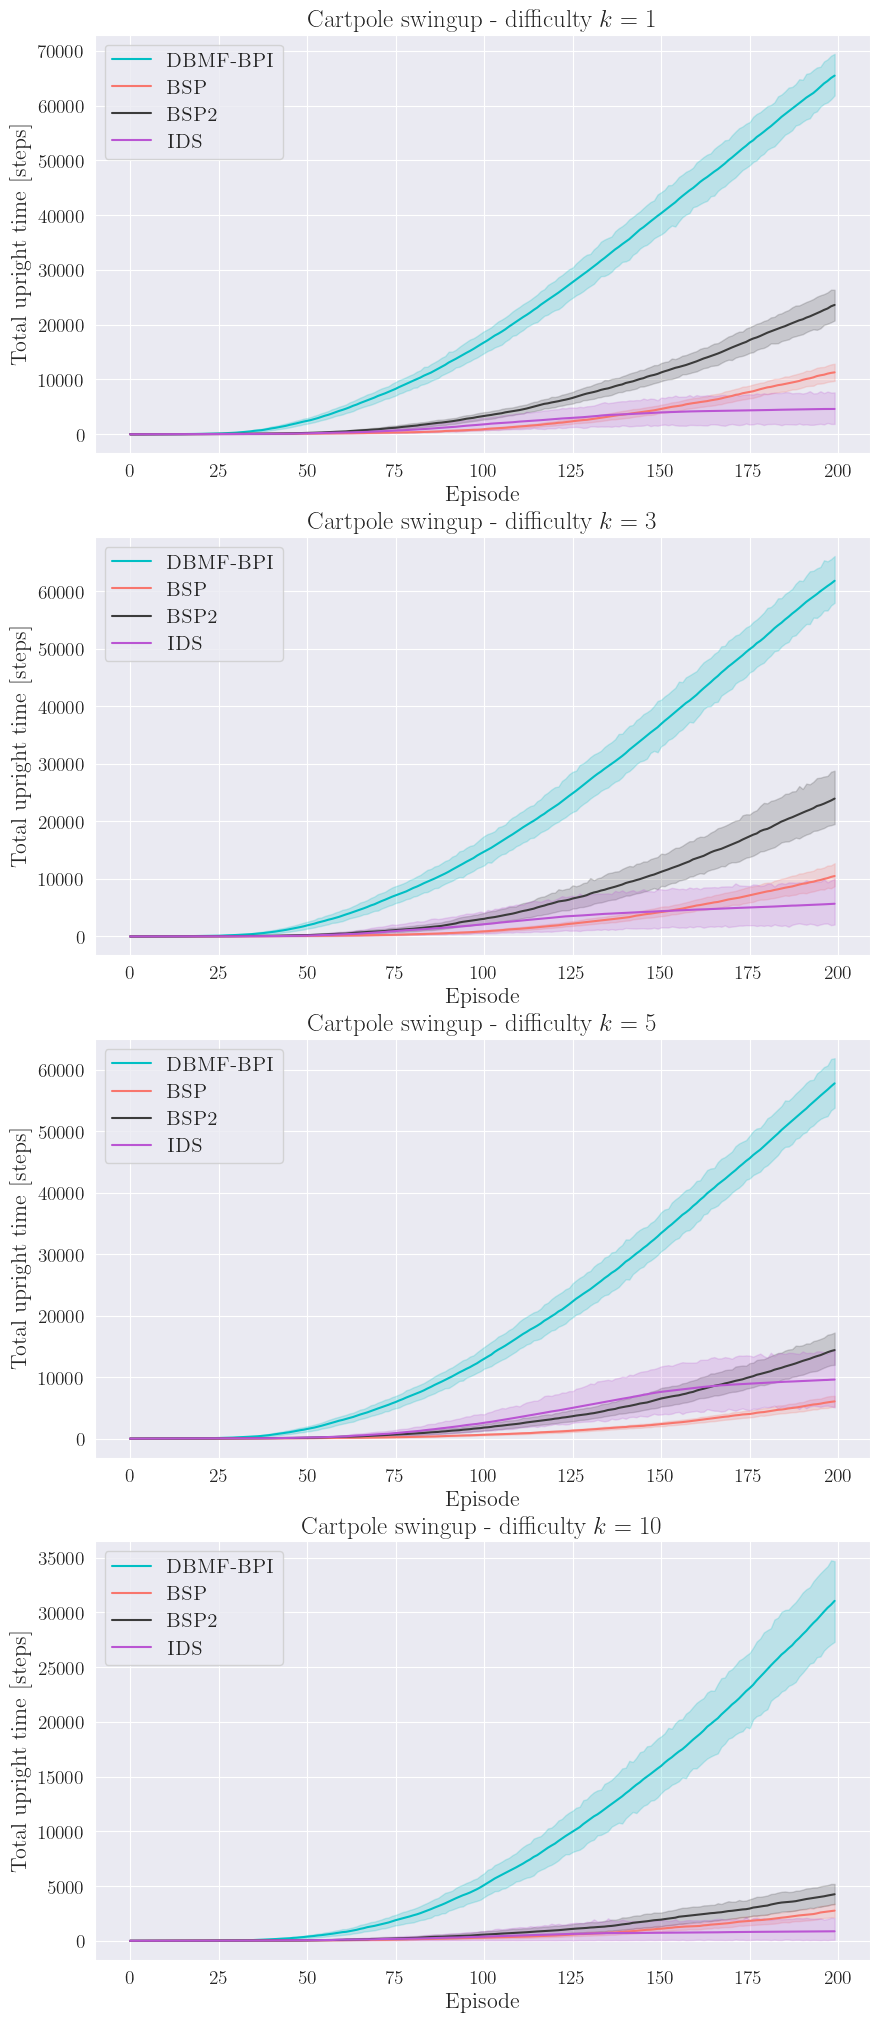

In [19]:
sns.set_style("darkgrid", rc=rc_parameters)

fig, ax = plt.subplots(len(sizes),1, figsize=(10,25))
colors = {
    'boot_dqn_torch':'#f8766d',
    'boot_dqn_torch_modified':'#3B3B3B',
    'explorative': '#00bfc4',
    'ids':'mediumorchid',
}
labels = {
    'boot_dqn_torch': r'\textsc{BSP}',
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative': r'\textsc{DBMF-BPI}',
    'ids': r'\textsc{IDS}',

}

for axis_id, size in enumerate(sizes):
    for agent_id, agent in enumerate(agents):
        ret1,df1 = get_cumulative_upright(data[agent][size], T)
        sns.lineplot(x='Episode', y='Value', data=df1, label=labels[agent], color=colors[agent], ax=ax[axis_id])

    ax[axis_id].set_xlabel(r'$\mathrm{Episode}$')
    ax[axis_id].set_ylabel(r'$\mathrm{Total \ upright \ time \ [steps]}$')
    ax[axis_id].set_title(r'$\mathrm{Cartpole \ swingup}$ - ' + f'difficulty $k={size}$')
    ax[axis_id].legend()
plt.savefig('figures/total_upright_time_full.pdf', bbox_inches='tight')

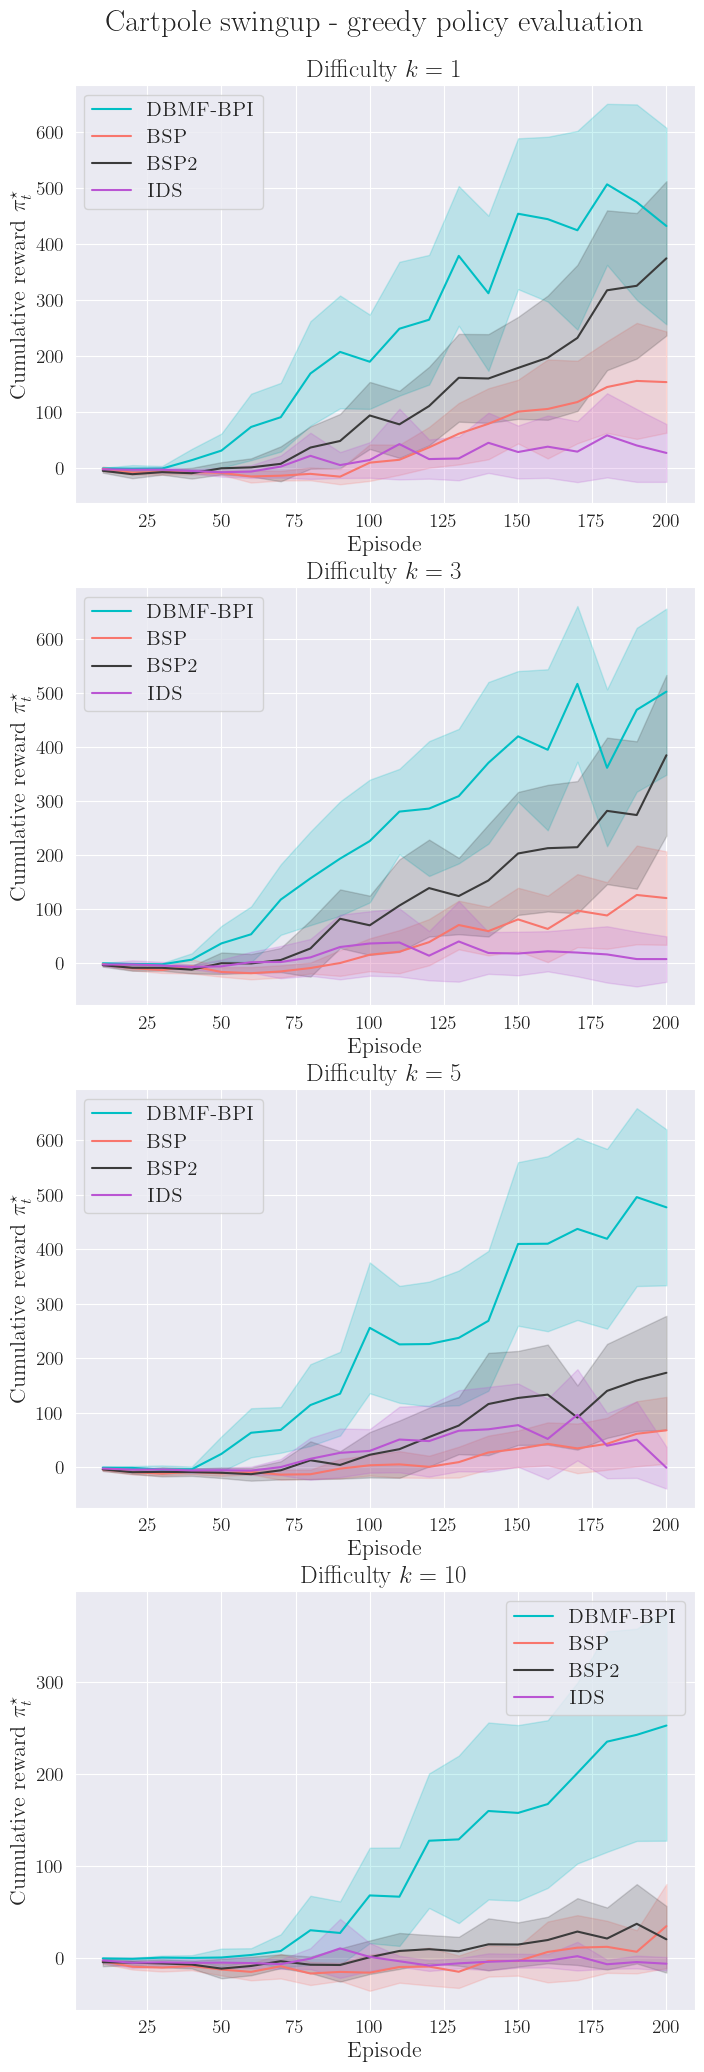

In [21]:
sns.set_style("darkgrid", rc=rc_parameters)
fig, ax = plt.subplots(len(sizes),1, figsize=(8,25))

labels = {
    'boot_dqn_torch': r'\textsc{BSP}',
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative': r'\textsc{DBMF-BPI}',
    'ids': r'\textsc{IDS}',
}
colors = {
    'boot_dqn_torch':'#f8766d',
    'boot_dqn_torch_modified':'#3B3B3B',
    'explorative': '#00bfc4',
    'ids':'mediumorchid',
}
def CE(x, c=0.95):
    from scipy.stats import t as tstudent
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N-1)
    
    mu = x.mean(-1).mean(0)
    s = x.std(-1, ddof=1).mean(0) + x.mean(-1).std(0, ddof=1)
    return mu, c * s/ np.sqrt(N)


for axis_id, size in enumerate(sizes):
    for agent_id, agent in enumerate(agents):
        greedy_data = get_greedy_eval(data, agent, size)
        mu, ce = CE(greedy_data)
        n = T // 10
        x = np.arange(1, n+1) * 10
        mu, ce = mu[:n], ce[:n]
        ax[axis_id].plot(x, mu, label=labels[agent], color=colors[agent])
        ax[axis_id].fill_between(x, mu-ce, mu+ce, alpha=0.2, color=colors[agent])
        ax[axis_id].legend()
        ax[axis_id].set_xlabel('Episode')
        ax[axis_id].set_ylabel(r'Cumulative reward $\pi_t^\star$')
        ax[axis_id].set_title(f'Difficulty $k={size}$')
plt.suptitle('Cartpole swingup - greedy policy evaluation',y=0.91)
plt.savefig('figures/greedy_evaluation.pdf', bbox_inches='tight')